# Assignment 2 2AMM10 2023-2024

## Group: [Fill in your group name]
### Member 1: [Fill in your name]
### Member 2: [Fill in your name]
### Member 3: [Fill in your name]

We need to install some specific libraries. The cell below installs torch_geometric for torch 2.6.0+cu124. In case the current version of torch is different, check [here](https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html) to see which versions (of both libraries) you should install. You might also need to install an old version of torch from [here](https://pytorch.org/get-started/previous-versions/)

**Note:** Do not install pyg_lib from the optional dependencies

In [135]:
!pip show torch

Name: torch
Version: 2.6.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /home/ubuntu/miniconda3/envs/dl/lib/python3.12/site-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-cusparselt-cu12, nvidia-nccl-cu12, nvidia-nvjitlink-cu12, nvidia-nvtx-cu12, setuptools, sympy, triton, typing-extensions
Required-by: openml-pytorch, pytorch-lightning, torchmetrics, torchvision


In [136]:
!pip install rdkit
!pip install torch_geometric
!pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.6.0+cu124.html

Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html


In [137]:
import pickle
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
import matplotlib.pyplot as plt

# More imports
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import random
from tqdm import tqdm
from torch.utils.data import DataLoader


In [138]:
with open('ass2_data/pos_data.pkl', 'rb') as f:
    pos_data = pickle.load(f)

with open('ass2_data/type_data.pkl', 'rb') as f:
    type_data = pickle.load(f)

with open('ass2_data/smiles.pkl', 'rb') as f:
    smiles_data = pickle.load(f)

data_split = np.load('ass2_data/data_split.npz')

train_idxes = data_split['train_idx']
test_idxes = data_split['test_idx']

formation_energy = np.load('ass2_data/formation_energy.npz')

fe = formation_energy['y'] # normalized formation energy
mu = formation_energy['mu']
std = formation_energy['sigma']

In [139]:
# shapes of lists
print("Length of data")
print(f"pos_data: {len(pos_data)}, type_data: {len(type_data)}, smiles: {len(smiles_data)}")
print("Idxes")
print(f"train: {len(train_idxes)}, test: {len(test_idxes)}, sum: {len(train_idxes) + len(test_idxes)}")

Length of data
pos_data: 129012, type_data: 129012, smiles: 129012
Idxes
train: 119012, test: 10000, sum: 129012


In [140]:
def at_number_to_atom_name(at_number):
    if at_number == 6:
        return 'C'
    elif at_number == 1:
        return 'H'
    elif at_number == 7:
        return 'N'
    elif at_number == 8:
        return 'O'
    elif at_number == 9:
        return 'F'
    elif at_number == 16:
        return 'S'
    else:
        return 'Unknown'

def inspect_structure(idx):
    smile = smiles_data[idx]
    pos = pos_data[idx]
    typ = type_data[idx]

    header = f"{'Atom':^5}│{'Number':^6}│{'x':^10}│{'y':^10}│{'z':^10}"
    line   = "─────┼──────┼──────────┼──────────┼──────────"
    print(header)
    print(line)

    for atom_num, (x, y, z) in zip(typ, pos):
        atom_sym = at_number_to_atom_name(atom_num)
        print(f"{atom_sym:^5}│{atom_num:^6}│{x:>10.3f}│{y:>10.3f}│{z:>10.3f}")
    print("")
    print("")
    print(f'SMILE: {smile}')
    print("")
    print("")
    print(f'Formation Energy: {fe[idx]*std + mu:.3f}')
    print(f'Formation Energy (normalized): {fe[idx]:.5f}')
    mol = Chem.MolFromSmiles(smile)
    if mol:
        # RDKit prefers 2‑D coordinates for nice depictions
        Chem.AllChem.Compute2DCoords(mol)
        img = Draw.MolToImage(mol, size=(300, 300))

        # Display with matplotlib (works both in notebooks and scripts)
        plt.figure(figsize=(3, 3))
        plt.axis('off')
        plt.imshow(img)
        plt.show()
        

Atom │Number│    x     │    y     │    z     
─────┼──────┼──────────┼──────────┼──────────
  C  │  6   │    -0.013│     1.086│     0.008
  H  │  1   │     0.002│    -0.006│     0.002
  H  │  1   │     1.012│     1.464│     0.000
  H  │  1   │    -0.541│     1.447│    -0.877
  H  │  1   │    -0.524│     1.438│     0.906


SMILE: C


Formation Energy: -17.172
Formation Energy (normalized): 5.72327


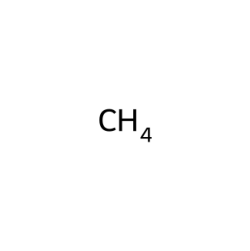

In [141]:
# methane
# Note how methane has a relatively high formation energy (compared to QM9)
# This correlates with lower thermodynamic stability and higher reactivity
# For example, methane readily burns in oxygen (CH₄ + 2O₂ → CO₂ + 2H₂O)
inspect_structure(0)

Atom │Number│    x     │    y     │    z     
─────┼──────┼──────────┼──────────┼──────────
  C  │  6   │    -0.752│     1.247│    -0.023
  C  │  6   │     0.200│     0.055│     0.014
  C  │  6   │     1.194│    -0.002│    -1.199
  C  │  6   │     2.363│    -0.718│    -0.601
  N  │  7   │     3.432│    -1.340│    -0.994
  O  │  8   │     4.044│    -1.743│     0.181
  N  │  7   │     3.325│    -1.355│     1.299
  C  │  6   │     2.297│    -0.727│     0.817
  C  │  6   │     1.077│    -0.018│     1.313
  H  │  1   │    -0.198│     2.192│     0.009
  H  │  1   │    -1.356│     1.243│    -0.936
  H  │  1   │    -1.438│     1.232│     0.830
  H  │  1   │    -0.390│    -0.869│    -0.020
  H  │  1   │     0.763│    -0.499│    -2.071
  H  │  1   │     1.485│     1.010│    -1.511
  H  │  1   │     1.337│     0.989│     1.664
  H  │  1   │     0.567│    -0.526│     2.135


SMILE: CC1Cc2nonc2C1


Formation Energy: -72.633
Formation Energy (normalized): 0.34440


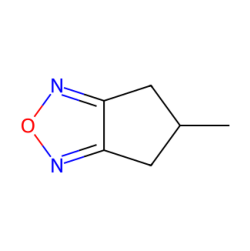

In [142]:
# random structure
inspect_structure(np.random.choice(range(len(smiles_data))))

### Determine system settings (to optimize training parameters)

In [159]:
print("System Info\n")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device: {torch.cuda.get_device_name(0)}")
else:
    print("Running on CPU.")


System Info

PyTorch version: 2.6.0+cu124
CUDA available: True
Device: NVIDIA GeForce RTX 3060 Ti


## Data Preprocessing

In [ ]:
# Setting variables
skip_training = True
MODEL_PATH = "smiles_model_task3.pth"
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

def tokenize_smiles(smiles):
    return list(smiles)

# Build vocabulary from a list of SMILES strings
def build_vocab(smiles_list):
    special_tokens = ['<pad>', '<sos>', '<eos>']
    all_chars = sorted(set(''.join(smiles_list)))
    itos = special_tokens + all_chars
    stoi = {s: i for i, s in enumerate(itos)}
    return stoi, itos


In [145]:
class SmilesDataset(Dataset):
    def __init__(self, smiles_list, stoi, max_len=120):
        self.stoi = stoi
        self.itos = {i: s for s, i in stoi.items()}
        self.max_len = max_len
        self.pad_idx = self.stoi['<pad>']
        self.sos_idx = self.stoi['<sos>']
        self.eos_idx = self.stoi['<eos>']
        self.data = [self.encode(s) for s in smiles_list]

    def encode(self, s):
        tokens = ['<sos>'] + tokenize_smiles(s) + ['<eos>']
        ids = [self.stoi[c] for c in tokens]
        if len(ids) < self.max_len:
            ids += [self.pad_idx] * (self.max_len - len(ids))
        return ids[:self.max_len]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq = torch.tensor(self.data[idx], dtype=torch.long)
        return seq[:-1], seq[1:]  # input, target


## Task 1

## Task 2

## Task 3

In [146]:
def is_valid_smiles(smiles):
    if smiles is None:
        return False
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None
    except:
        return False

def canonicalize(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return Chem.MolToSmiles(mol, canonical=True)
        return 'None'
    except:
        return 'None'

In [147]:
canonicalize("COO"), canonicalize("O(C)O")

('COO', 'COO')

In [148]:
is_valid_smiles("COO"), is_valid_smiles("O(C)O"), is_valid_smiles("C##")

(True, True, False)

In [149]:
class SmilesLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256, num_layers=2, dropout=0.1, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, 
                            batch_first=True, dropout=dropout)
        self.output = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        embedded = self.embedding(x)
        out, hidden = self.lstm(embedded, hidden)
        logits = self.output(out)
        return logits, hidden


## Training Loop

In [ ]:
def train_model(model, train_dataset, stoi, epochs=10, batch_size=64, lr=1e-3,
                device='cuda' if torch.cuda.is_available() else 'cpu'):

    batch_size = 256 if torch.cuda.is_available() else 64
    pad_idx = stoi['<pad>']
    model = model.to(device)

    if skip_training:
      print("Skipping training. Loading saved model weights...")
      model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
      model = model.to(device)
      return model

    model.train()
    loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss(ignore_index=pad_idx)

    for epoch in range(1, epochs+1):
        total_loss = 0.0
        loop = tqdm(loader, desc=f"Epoch {epoch}")
        for x, y in loop:
            x, y = x.to(device), y.to(device)
            logits, _ = model(x)

            loss = loss_fn(logits.view(-1, logits.size(-1)), y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(loader)
        print(f"Epoch {epoch} completed. Avg Loss: {avg_loss:.4f}")

    torch.save(model.state_dict(), MODEL_PATH)
    print(f"Model saved to {MODEL_PATH}")
    return model


In [151]:
train_smiles = [smiles_data[i] for i in train_idxes]
stoi, itos = build_vocab(train_smiles)
train_dataset = SmilesDataset(train_smiles, stoi, max_len=120)

model = SmilesLSTMModel(
    vocab_size=len(stoi),
    embed_dim=256,
    hidden_dim=512,
    num_layers=2,
    dropout=0.1,
    pad_idx=stoi['<pad>']
)

model = train_model(model, train_dataset, stoi, epochs=10)



Epoch 1: 100%|██████████| 465/465 [00:30<00:00, 15.08it/s, loss=0.619]


Epoch 1 completed. Avg Loss: 0.7804


Epoch 2: 100%|██████████| 465/465 [00:30<00:00, 15.29it/s, loss=0.586]


Epoch 2 completed. Avg Loss: 0.5952


Epoch 3: 100%|██████████| 465/465 [00:27<00:00, 16.97it/s, loss=0.565]


Epoch 3 completed. Avg Loss: 0.5672


Epoch 4: 100%|██████████| 465/465 [00:29<00:00, 15.85it/s, loss=0.543]


Epoch 4 completed. Avg Loss: 0.5530


Epoch 5: 100%|██████████| 465/465 [00:34<00:00, 13.63it/s, loss=0.547]


Epoch 5 completed. Avg Loss: 0.5441


Epoch 6: 100%|██████████| 465/465 [00:29<00:00, 15.94it/s, loss=0.532]


Epoch 6 completed. Avg Loss: 0.5377


Epoch 7: 100%|██████████| 465/465 [00:31<00:00, 14.56it/s, loss=0.525]


Epoch 7 completed. Avg Loss: 0.5328


Epoch 8: 100%|██████████| 465/465 [00:31<00:00, 14.97it/s, loss=0.528]


Epoch 8 completed. Avg Loss: 0.5290


Epoch 9: 100%|██████████| 465/465 [00:31<00:00, 14.83it/s, loss=0.525]


Epoch 9 completed. Avg Loss: 0.5256


Epoch 10: 100%|██████████| 465/465 [00:30<00:00, 15.22it/s, loss=0.522]


Epoch 10 completed. Avg Loss: 0.5227
Model saved to smiles_model.pth


### Sampling

In [ ]:
def sample_smiles(model, stoi, itos, max_length=120, temperature=1.0, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.eval()
    generated = []
    sos_idx = stoi['<sos>']
    eos_idx = stoi['<eos>']

    with torch.no_grad():
        input_seq = torch.tensor([[sos_idx]], dtype=torch.long).to(device)
        hidden = None

        for _ in range(max_length):
            logits, hidden = model(input_seq, hidden)
            logits = logits[:, -1, :] / temperature
            probs = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            next_idx = next_token.item()

            if next_idx == eos_idx:
                break

            generated.append(itos[next_idx])
            input_seq = next_token

    return ''.join(generated)


In [153]:
def generate_smiles_batch(model, stoi, itos, n=5000, temperature=1.0):
    samples = []
    for _ in tqdm(range(n), desc="Generating SMILES"):
        smi = sample_smiles(model, stoi, itos, temperature=temperature)
        samples.append(smi)
    return samples


### Evaluation

In [ ]:
def evaluate_smiles(generated_smiles, train_smiles):
    train_set = set([canonicalize(s) for s in train_smiles])
    valid_smiles = []
    canonical_valid = []

    for smi in generated_smiles:
        if is_valid_smiles(smi):
            can = canonicalize(smi)
            if can != 'None':
                valid_smiles.append(smi)
                canonical_valid.append(can)

    total_generated = len(generated_smiles)
    total_valid = len(valid_smiles)
    unique_valid = len(set(canonical_valid))
    novel_valid = len([s for s in set(canonical_valid) if s not in train_set])

    return {
        "validity": total_valid / total_generated * 100,
        "uniqueness": unique_valid / total_valid * 100 if total_valid > 0 else 0,
        "novelty": novel_valid / total_valid * 100 if total_valid > 0 else 0,
    }


In [ ]:
samples = generate_smiles_batch(model, stoi, itos, n=5000, temperature=0.9)
metrics = evaluate_smiles(samples, train_smiles)
print("Evaluation Results:")
for k, v in metrics.items():
    print(f"{k.capitalize()}: {v:.2f}%")

with open("generated_smiles.txt", "w") as f:
    for smi in samples:
        f.write(smi + "\n")


Generating SMILES: 100%|██████████| 5000/5000 [01:28<00:00, 56.51it/s]


Evaluation Results:
Validity: 98.54%
Uniqueness: 97.93%
Novelty: 30.40%
